In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/Users/bmmorris/git/trappist1sc/output/sc_whitened.dat'
cadence, mjd, flux = np.loadtxt(path, unpack=True)
times = jd = mjd + 2457700

In [3]:
from batman import TransitParams
params = TransitParams()
params.per = 4.049959
params.t0 = 2450000 + 7670.14227
params.inc = 89.89
params.a = 39.68
params.rp = params.rp0 = params.rp1 = (0.826/100)**0.5
params.duration = 49.33/60/24
params.b = 0.08
params.u = [1.00, -0.04]
params.limb_dark = 'quadratic'
params.w = 0
params.ecc = 0

In [4]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/libra/')
from libra import mask_simultaneous_transits_trappist

In [5]:
mask = mask_simultaneous_transits_trappist(times, 'd')

In [6]:
np.count_nonzero(mask)/len(mask)

0.9547542744938221

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:889: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightcurve.py:890: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
/Users/bmmorris/git/friedrich/friedrich/lightc

(0.9, 1.1)

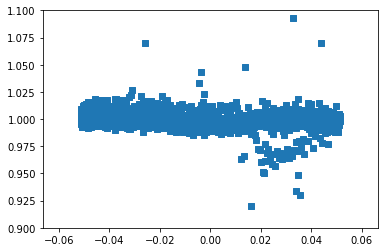

In [7]:
import sys

sys.path.insert(0, '/Users/bmmorris/git/friedrich/')
from friedrich.lightcurve import LightCurve, concatenate_transit_light_curves

lc = LightCurve(times[mask], flux[mask])
split = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=1))
transits = split.get_transit_light_curves(params)
all_transits = concatenate_transit_light_curves(transits)

for transit in transits:
    transit_masked = transit.mask_in_transit(params)
    transit.fluxes /= np.median(transit_masked['fluxes'])
    
#     transit.plot()
all_transits = concatenate_transit_light_curves(transits)

times = ((all_transits.times.jd - params.t0) % params.per)
times[times > params.per/2] -= params.per
all_fluxes = all_transits.fluxes[np.argsort(times)]
times = times[np.argsort(times)]
plt.scatter(times, all_fluxes, marker=',')
plt.ylim([0.9, 1.1])

In [8]:
from libra import trappist1

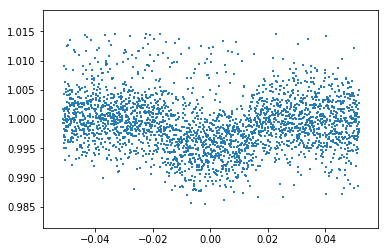

In [9]:
outliers = np.abs(all_fluxes - 1) > 0.015
times = times[~outliers]
all_fluxes = all_fluxes[~outliers]
plt.scatter(times, all_fluxes, marker=',', s=1)
yerr = np.std(all_fluxes[times < -0.02])/2

<Container object of 3 artists>

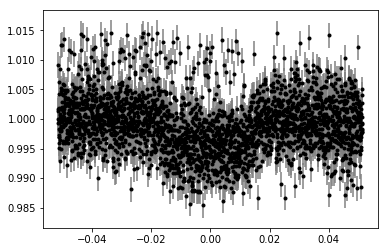

In [10]:
plt.errorbar(times, all_fluxes, yerr, color='k', fmt='.', ecolor='gray')

In [11]:
def quadratic_to_kipping(u):
    q1 = (u[0] + u[1])**2
    q2 = 0.5 * u[0] / (u[0] + u[1])
    return np.array([q1, q2])

u = [1.0, -0.04]
u_err = [0.02, 0.04]
q = quadratic_to_kipping([u[0], u[1]])
q_err = abs(quadratic_to_kipping([u[0]+u_err[0], u[1]+u_err[1]]) - q)
b_prior = 0.08
b_prior_err = 0.10

In [23]:
from copy import deepcopy
import batman

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

def aRs_i(p0, T14, b, transit_params):
    """
    Convert from duration and impact param to a/Rs and inclination

    Parameters
    ----------
    transit_params : `batman.TransitParams`
        Transit parameters
    Returns
    -------
    aRs : float
        Semi-major axis in units of stellar radii
    i : float
        Orbital inclination in degrees
    """
    eccentricity = transit_params.ecc
    omega = transit_params.w
    P = transit_params.per

    # Eccentricity term for b -> a/rs conversion
    beta = (1 - eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega)))

    # Eccentricity term for duration equation:
    c = (np.sqrt(1 - eccentricity**2) /
         (1 + eccentricity*np.sin(np.radians(omega))))

    i = np.arctan(beta * np.sqrt((1 + p0)**2 - b**2) /
                  (b * np.sin(T14*np.pi / (P*c))))
    aRs = b/(np.cos(i) * beta)
    return aRs, np.degrees(i)

def transit_model(theta, x):
    r0, r1, q1, q2, b, t14, f0 = theta
    trial_params = deepcopy(params)
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    trial_params.t0 = 0
    trial_params.u = kipping_to_quadratic([q1, q1])

    a, inc = aRs_i(r0, t14, b, trial_params)
    trial_params.a = a
    trial_params.inc = inc
    
    m = batman.TransitModel(trial_params, x, exp_time=x[1]-x[0], supersample_factor=3)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, q1, q2, b, t14, f0 = theta

    model = transit_model(theta, x) 
    return -0.5*(np.sum((model - y)**2 / yerr**2))


def lnprior(theta):
    r0, r1, q1, q2, b, t14, f0 = theta

    if 0 < r0 < 0.3 and 0.0 < r1 < 0.3 and 0 < f0 < 1.5 and 0 < b < 1.5 and 0 < t14 < 1/24 and 0 < q1 < 1 and 0 < q2 < 1:
        return -0.5 * (b - b_prior)**2/b_prior_err**2 - 0.5 * (q1 - q[0])**2/q_err[0]**2 - 0.5 * (q2 - q[1])**2/q_err[1]**2
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 7, 14
pos = []

q1 = (params.u[0] + params.u[1])**2
q2 = 0.5 * params.u[0] / (params.u[0] + params.u[1])

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, q1, q2, params.b, params.duration, 1] + 1e-3*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=8)

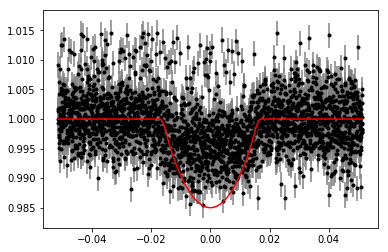

In [ ]:
init_f = transit_model([params.rp, params.rp, q1, q2, params.b, params.duration, 1], times)

plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [ ]:
sampler.run_mcmc(pos, 10000); 

In [ ]:
from corner import corner

corner(sampler.chain[:, 5000:, :-1].reshape((-1, ndim-1)), truths=[params.rp, params.rp, None, None, params.b, params.duration], 
       labels=['$p_0$', '$p_1$', '$q_1$', '$q_2$', '$b$', '$T_\mathrm{14}$'], show_titles=True, #fig=fig, 
       title_fmt='.6f', title_kwargs=dict(fontsize=10));

In [ ]:
from corner import corner

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-5)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.4f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.08, 0.32])
    if i == 3: 
        axis.set_xlim([0.05, 0.1])
plt.savefig('corner_quad_trappist1d.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(4, 3))

fmax = 0
for p, label in zip(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3)).T, 
                    ['$p_0$', '$p_1$']):
    n, _, _ = plt.hist(p, bins=20, histtype='stepfilled', label=label)
    fmax = max([n.max(), fmax])
ax = plt.gca()
ax.grid(ls=':')
ax.legend()
ax.set(yticks=[])

for s in ['right', 'top', 'left']:
    ax.spines[s].set_visible(False)
plt.savefig('trappist1d_agreement.pdf', bbox_inches='tight')

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(sampler.chain[:, 5000:, :2].reshape((-1, ndim-3))[:, 0],
          sampler.chain[:, 5000:, :2].reshape((-1, ndim-3))[:, 1],
          equal_var=False)

In [ ]:
np.savetxt('trappist1d_samples.txt', sampler.flatchain)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, all_fluxes, marker='.', s=1, 
              color='k', rasterized=True)

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, all_fluxes - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k', rasterized=True)

ax[0].set_ylim([0.98, 1.015])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('trappist1d_residuals.pdf', bbox_inches='tight', dpi=250)